In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

np.seterr(all="ignore")

from threeML import *
from threeML.io.package_data import get_path_of_data_file
from threeML.io import update_logging_level
from threeML.utils.data_download.Fermi_LAT.download_LAT_data import LAT_dataset
from astropy.io import fits as pyfits

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# This if you want to toggle different type of logging level.
update_logging_level("INFO")
log.error("error")
log.info("info")
log.debug("debug")

22:02:50 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=502208;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=698489;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

22:02:51 WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=366515;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=540099;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=304774;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=337165;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

22:02:53 ERROR     error                                                                           ]8;id=638449;file:///var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/ipykernel_9920/3699701126.py\3699701126.py]8;;\:]8;id=738965;file:///var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/ipykernel_9920/3699701126.py#29\29]8;;\

         INFO      info                                                                            ]8;id=336653;file:///var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/ipykernel_9920/3699701126.py\3699701126.py]8;;\:]8;id=565910;file:///var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/ipykernel_9920/3699701126.py#30\30]8;;\

## GtBurst
Gtburst contains all the classes and methods to perform Fermi LAT data. It internally uses the official fermitools software. Here an example to list the IRFS available:


In [2]:
from GtBurst import IRFS

irfs = IRFS.IRFS.keys()
print(irfs)

odict_keys(['p7rep_transient', 'p7rep_source', 'p7rep_clean', 'p7rep_ultraclean', 'p8r2_transient100e', 'p8r2_transient100', 'p8r2_transient020e', 'p8r2_transient020', 'p8r2_transient010e', 'p8r2_transient010', 'p8r2_source', 'p8r2_clean', 'p8r2_ultraclean', 'p8r2_ultracleanveto', 'p8r2_transient100s', 'p8r2_transient015s', 'p8_transient100e', 'p8_transient100', 'p8_transient020e', 'p8_transient020', 'p8_transient010e', 'p8_transient010', 'p8_source', 'p8_clean', 'p8_ultraclean', 'p8_ultracleanveto', 'p8_sourceveto', 'p8_transient100s', 'p8_transient015s'])


## The LAT Transient Builder
Let's see how to make a plug in for the unbinned analysis of Fermi LAT data. First we use the information form a triggered GRB to obtain MET, RA and DEC, that are needed for the analysis.


In [3]:
from GtBurst.TriggerSelector import TriggerSelector

myFavoriteGRB = "bn190114873"


def findGRB(grb_name):
    a = TriggerSelector()
    a.downloadList()
    myGRB = {}
    for x in a.data:
        if x[0] == myFavoriteGRB:
            myGRB["MET"] = float(x[1])
            myGRB["RA"] = float(x[3])
            myGRB["DEC"] = float(x[4])
            myGRB["ERR"] = float(x[5])
            return myGRB
            pass
    return None

In [4]:
myGRB = findGRB(myFavoriteGRB)
print(myGRB)

{'MET': 569192227.626, 'RA': 54.51, 'DEC': -26.939, 'ERR': 0.05}


Then, we download LAT data and we build the transient builder, we want to analyze 1000 seconds since the trigger. Let's start download the data:


In [5]:
tstart = 0
tstop = 1000

In [6]:
myLATdataset = LAT_dataset()

myLATdataset.make_LAT_dataset(
    ra=myGRB["RA"],
    dec=myGRB["DEC"],
    radius=12,
    trigger_time=myGRB["MET"],
    tstart=tstart,
    tstop=tstop,
    data_type="Extended",
    destination_directory=".",
    Emin=100.0,
    Emax=10000.0,
)  # Energies are MeV (this is from 100 MeV to 10 GeV)

22:03:06 INFO      Query parameters:                                                       ]8;id=492321;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=128618;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#262\262]8;;\

         INFO                          coordfield = 54.5100,-26.9390                       ]8;id=172318;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=290213;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         coordsystem = J2000                                  ]8;id=976809;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=725045;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          shapefield = 12                                     ]8;id=507885;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=660458;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                           timefield = 569192227.626,569193227.626            ]8;id=656968;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=858605;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                            timetype = MET                                    ]8;id=14928;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=962342;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         energyfield = 100.000,10000.000                      ]8;id=629540;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=25910;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO              photonOrExtendedOrNone = Extended                               ]8;id=515651;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=283657;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         destination = query                                  ]8;id=439706;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=709258;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          spacecraft = checked                                ]8;id=87542;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=533740;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO      Query ID: 86ad4d2b3b3e5065f0f0a976e6fc8315                              ]8;id=206500;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=676627;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#271\271]8;;\

         INFO      Estimated complete time for your query: 15 seconds                      ]8;id=748832;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=886764;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#428\428]8;;\

         INFO      If this download fails, you can find your data at                       ]8;id=253943;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=879893;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#437\437]8;;\
                  https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/QueryResults.cgi?id=L2311031                         
                  80307BE96CEF202 (when ready)                                                                     

22:03:12 INFO      Downloading FT1 and FT2 files...                                        ]8;id=447173;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=113559;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#527\527]8;;\

22:03:15 WARNING   Only one FT1 file provided. Skipping the merge...                        ]8;id=784912;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=240068;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#98\98]8;;\

Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.rsp...
time -p gtselect infile=./bn190114873/gll_ft1_tr_bn190114873_v00.fit outfile=__temp_ft1.fits ra=54.51 dec=-26.939 rad=15.0 tmin=569192226.626 tmax=569193228.626 emin=10.0 emax=300000.0 zmin=0.0 zmax=110.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.13
user 0.10
sys 0.03
Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.pha...
 *  Get energy binning from the response matrix...

    done.

 *  Run gtbindef and gtbin and bin in energy and time...

time -p gtbindef bintype="E" binfile=__ebins.txt outfile=__energyBins.fits energyunits="keV" chatter=2 clobber=yes debug=no gui=no mode="ql"


This is gtbindef version HEAD
real 0.17
user 0.03
sys 0.02
time -p gtbin evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/__temp_ft1.fits scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=__gtllebin__pha2.pha algorithm="PHA2" ebinalg="FILE" emin=30.0 emax=200000.0 ebinfile=__energyBins.fits tbinalg="LIN" tstart=569192227.626 tstop=569193227.626 dtime=4.096 tbinfile=NONE coordsys="CEL" axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=1 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD


real 2.69
user 2.38
sys 0.30

    done.

 *  Transform gtbin output in CSPEC format...

    done.

 *  Updating keywords in the headers of the CSPEC file...

    done.

gtllebin done!


We want perform a time resolved analysis. So, first we look at the data. We can play with the ROI selection and the cut.


In [7]:
roi = 10
zmax = 110.0
thetamax = 180.0
irfs = "p8_transient020e"
strategy = "time"
myLATdataset.extract_events(roi, zmax, irfs, thetamax, strategy="time")

time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit evtable="EVENTS" outfile="gll_ft1_tr_bn190114873_v00_mkt.fit" apply_filter=yes overwrite=no header_obstimes=yes tstart=569192227.626 tstop=569193227.626 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 0.13
user 0.07
sys 0.03

Using 305 data

time -p gtselect infile=gll_ft1_tr_bn190114873_v00_mkt.fit outfile=gll_ft1_tr_bn190114873_v00_filt.fit ra=54.51 dec=-26.939 rad=10.0 tmin=569192227.626 tmax=569193227.626 emin=100.0 emax=10000.0 zmin=0.0 zmax=110.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=

Done.
real 0.14
user 0.10
sys 0.03

Selected 251 events.


22:03:19 INFO      Extracted 251 events                                                    ]8;id=274046;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=626955;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#670\670]8;;\

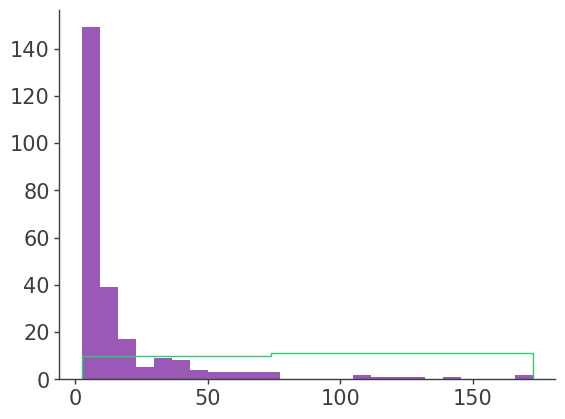

In [8]:
%matplotlib inline
event_file = pyfits.open(myLATdataset.filt_file)
event_times = sorted(event_file["EVENTS"].data["TIME"] - myGRB["MET"])
intervals = event_times[0::10]
_ = plt.hist(event_times)
_ = plt.hist(event_times, intervals, histtype="step")
# plt.show()

tstarts and tstops are defined as strings, with somma separated values for the starts and the ends of the time bins: For example tsrats="0,1,10" and tstops="1,10,20". To convert arrays in string we use these few lines of code:


In [9]:
tstarts = tstops = ""
for t0, t1 in zip(intervals[:-1], intervals[1:]):
    tstarts += "%.4f," % t0
    tstops += "%.4f," % t1
    pass
tstarts = tstarts[:-1].replace("-", "\\-")
tstops = tstops[:-1].replace("-", "\\-")

We can now make an instance the LAT transient builder


In [10]:
analysis_builder = TransientLATDataBuilder(
    myLATdataset.grb_name,
    outfile=myLATdataset.grb_name,
    roi=roi,
    tstarts=tstarts,
    tstops=tstops,
    irf=irfs,
    zmax=zmax,
    galactic_model="template",
    particle_model="isotr template",
    datarepository=".",
)
df = analysis_builder.display(get=True)

outfile                                                       190114873
roi                                                                  10
tstarts               2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.54...
tstops                3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.98...
zmax                                                              110.0
emin                                                              100.0
emax                                                           100000.0
irf                                                    p8_transient020e
galactic_model                                                 template
particle_model                                           isotr template
source_model                                                  PowerLaw2
tsmin                                                              20.0
strategy                                                           time
thetamax                                                        

In [11]:
tstops

'3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754'

The run method will run (using gtburst) all the fermitools needed to obtain the needed file for the likelihood analysis (livetimecubes, exposure maps. It will also perfom a simple likelihood analysis with the standard likelihood of the fermitools (pylikelihood). The dataproducts created here will be used by threeML to make the fit.


In [12]:
LAT_observations = analysis_builder.run(include_previous_intervals=True)

Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/scripts/doTimeResolvedLike.py
Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gtdiffrsp_mp.py
Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gtexpmap_mp.py
Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gtltcube_mp.py
Changing permission to /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/GtBurst/gtapps_mp/gttsmap_mp.py


         INFO      About to run the following command:                                 ]8;id=922793;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=202025;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#636\636]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py 190114873 --outfile                                  
                  '190114873' --roi 10.000000 --tstarts                                                            
                  '2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.68                             
                  89,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165                             
                  ,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262' --tstops                                       
                  '3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.01                             
                  17,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.783                             
                  4,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754' --zmax                                       
                  110.000000 --emin 100.000000 --emax 100000.000000 --irf                                          
                  'p8_transient020e' --galactic_model 'template' --particle_model                                  
                  'isotr template' --source_model 'PowerLaw2' --tsmin 20.000000                                    
                  --strategy 'time' --thetamax 180.000000 --spectralfiles 'no'                                     
                  --liketype 'unbinned' --optimizeposition 'no' --datarepository '.'                               
                  --ltcube '' --expomap '' --ulphindex -2.000000 --flemin 100.000000                               
                  --flemax 10000.000000 --fgl_mode 'fast'                                                          

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   25.19240     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .29E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.71579     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .58E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Requested intervals:
------------------------------------------------------
2.6996               - 3.6358
3.6358               - 3.9968
3.9968               - 4.4024
4.4024               - 4.7375
4.7375               - 5.0909
5.0909               - 5.5471
5.5471               - 5.9896
5.9896               - 6.3998
6.3998               - 6.6889
6.6889               - 7.0117
7.0117               - 7.2936
7.2936               - 7.7731
7.7731               - 8.2167
8.2167               - 8.8763
8.8763               - 9.6573
9.6573               - 10.568
10.568               - 12.0568
12.0568              - 14.6165
14.6165              - 17.7834
17.7834              - 21.4962
21.4962              - 30.0798
30.0798              - 40.8747
40.8747              - 48.7118
48.7118              - 73.7262
73.7262              - 172.5754

Data files:
-----------
eventfile            /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit
ft2file      

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   4.786573     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   5.901543     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .70E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_3.6358-3.9968.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 8.52
user 7.82
sys 0.68
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.43105     FROM MIGRAD    STATUS=CONVERGED     67 CALLS       68 TOTAL
                     EDM=   .19E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   11.37565     FROM MIGRAD    STATUS=CONVERGED     74 CALLS       75 TOTAL
                     EDM=   .16E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  9.4%

  EXT PARAMETER                            

Total time in Good Time Intervals:        0.3350999355316162
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_4.4024-4.7375.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' source_model='PowerLaw2'

Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_4.4024-4.7375.xml 0.3350999355316162 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   7.632503     FROM MIGRAD    STATUS=CONVERGED     61 CALLS       62 TOTAL
                     EDM=   .99E-06  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  5.3%

  EXT PARAMETER                            

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_5.0909-5.5471.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='5.0909' tstop='5.5471' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   10.79486     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .15E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   6.844639     FROM MIGRAD    STATUS=CONVERGED     66 CALLS       67 TOTAL
                     EDM=   .31E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval5.5471-5.9896/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 8.25
user 7.50
sys 0.72
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval5.5471-5.9896/gll_ft1_tr_bn190114873_v00_filt.fit
Spacecraft file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit
Exposure map: gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Exposure cube: gll_ft1_tr_bn190114873_v00_filt_ltcube.fit
IRFs: P8R3_TRANSIENT020E_V3
Source model file: 190114873_LAT_xmlmodel_5.5471-5.9896.xml
Optimizer: Minuit

Performing likelihood fit...
Data  10.0
srcName  2.576925063095601e-06
srcName  10.000748366300273
srcName  0.0005360043373690395
srcName  0.00012916130

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   8.317516     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .68E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   12.58093     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .10E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure()


Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templates/FornaxA.fits...
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using spatial model SpatialMap...
Kept 1 point sources from the FGL catalog
-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_6.3998-6.6889.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_6.3998-6.6889.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval6.3998-6.6889/gll_ft1_tr_bn190114873_v00_filt.fit" evtable

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   18.30164     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_7.0117-7.2936.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='7.0117' tstop='7.2936' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   14.90094     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .44E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   13.18701     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .24E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.5%

  EXT PARAMETER                            

adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval7.2936-7.7731/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 8.52
user 7.76
sys 0.74
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval7.2936-7.7731/gll_ft1_tr_bn190114873_v00_filt.fit
Spacecraft file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit
Exposure map: gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Exposure cube: gll_ft1_tr_bn190114873_v00_filt_ltcube.fit
IRFs: P8R3_TRANSIENT020E_V3
Source model file: 190114873_LAT_xmlmodel_7.2936-7.7731.xml
Optimizer: Minuit

Performing likelihood fit...
Data  10.0
sr

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   24.59086     FROM MIGRAD    STATUS=CONVERGED     57 CALLS       58 TOTAL
                     EDM=   .13E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   28.24928     FROM MIGRAD    STATUS=CONVERGED     56 CALLS       57 TOTAL
                     EDM=   .18E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_8.2167-8.8763.xml 0.659600019454956 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templates/FornaxA.fits...
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using spatial model SpatialMap...
Kept 1 point sources from the FGL catalog
-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_8.2167-8.8763.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   29.59265     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .12E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_9.6573-10.568.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='9.6573' tstop='10.568' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   30.55516     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .11E-04  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.1%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   29.31981     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .64E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  3.9%

  EXT PARAMETER                            

/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval10.568-12.0568/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 8.56
user 7.63
sys 0.76
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval10.568-12.0568/gll_ft1_tr_bn190114873_v00_filt.fit
Spacecraft file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit
Exposure map: gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Exposure cube: gll_ft1_tr_bn190114873_v00_filt_ltcube.fit
IRFs: P8R3_TRANSIENT020E_V3
Source model file: 190114873_LAT_xmlmodel_10.568-12.0568.xml
Optimizer: Minuit

Performing likelihood fit...
Data  10.0
srcName  2.576925063095601e-06
srcName  9.908951061804515
srcName  0.0018046854663908737
srcName  0.008596113

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   38.58473     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .91E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  4.2%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   41.85635     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .15E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templates/FornaxA.fits...
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using spatial model SpatialMap...
Kept 1 point sources from the FGL catalog
-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_14.6165-17.7834.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_14.6165-17.7834.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval14.6165-17.7834/gll_ft1_tr_bn190114873_v00_filt.fit" e

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   40.63160     FROM MIGRAD    STATUS=CONVERGED     71 CALLS       72 TOTAL
                     EDM=   .94E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_21.4962-30.0798.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='21.4962' tstop='30.0798' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   34.58971     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .11E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   51.56070     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval30.0798-40.8747/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_30.0798-40.8747.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval30.0798-40.8747/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 7.74
user 7.07
sys 0.66
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/t

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   66.71287     FROM MIGRAD    STATUS=CONVERGED     64 CALLS       65 TOTAL
                     EDM=   .42E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_48.7118-73.7262.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' source_model='PowerLaw2'

Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_48.7118-73.7262.xml 25.014400005340576 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templa

22:20:56 INFO      The ft2 file does not exist. Please examine!                        ]8;id=579403;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=249106;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=40201;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=817786;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=474088;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=716915;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval10.568-12.0568/gll_ft2_tr_bn190114873_v00.fit                                            

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=854630;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=429534;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=902510;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=753063;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=118636;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=457151;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval12.0568-14.6165/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=823805;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=142519;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=445110;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=889689;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=755135;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=132469;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval14.6165-17.7834/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=304601;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=386667;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=314900;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=297691;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=310914;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=190988;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval17.7834-21.4962/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=867239;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=899299;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=389591;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=686008;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=701827;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=393479;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval2.6996-3.6358/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=815951;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=400842;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=213044;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=926014;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=906139;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=718352;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval21.4962-30.0798/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=745464;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=253801;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=595058;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=56302;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=351368;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=638604;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval3.6358-3.9968/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=266160;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=278804;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=904864;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=40652;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=884170;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=549216;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval3.9968-4.4024/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=336612;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=832772;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=234379;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=185105;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=201960;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=119318;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval30.0798-40.8747/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=765773;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=830078;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=873124;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=651800;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=566030;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=333554;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval4.4024-4.7375/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=636103;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=627981;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=293593;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=261984;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=969079;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=636803;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval4.7375-5.0909/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=363096;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=304467;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=764572;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=471363;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=816420;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=480438;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval40.8747-48.7118/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=563989;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=121716;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=891720;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=214111;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=944879;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=894928;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval48.7118-73.7262/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=954322;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=810355;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=606256;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=432511;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=465582;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=452897;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval5.0909-5.5471/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=800324;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=547125;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=137018;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=806546;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=756663;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=616128;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval5.5471-5.9896/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=111519;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=685700;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=714583;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=693701;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=446877;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=769589;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval5.9896-6.3998/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=850095;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=288381;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=612606;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=587445;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=329720;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=596520;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval6.3998-6.6889/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=651795;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=567535;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=373505;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=361764;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=229918;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=673479;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval6.6889-7.0117/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=661755;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=683149;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=991471;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=982784;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=821836;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=219213;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval7.0117-7.2936/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=912975;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=312856;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=134723;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=605780;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=176400;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=900037;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval7.2936-7.7731/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=951688;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=329873;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=625708;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=330553;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=502283;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=774742;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval7.7731-8.2167/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=658059;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=716326;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=55189;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=24567;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=417828;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=766337;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval73.7262-172.5754/gll_ft2_tr_bn190114873_v00.fit                                          

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=495194;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=39280;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=692005;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=210182;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=292101;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=204038;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval8.2167-8.8763/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=608601;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=369643;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=668310;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=820276;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=173736;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=378407;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval8.8763-9.6573/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=658911;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=765768;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#722\722]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=162854;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=78744;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#723\723]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=16175;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=205245;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#739\739]8;;\
                  interval9.6573-10.568/gll_ft2_tr_bn190114873_v00.fit                                             

 At this point we can create the FermiLATLike plugins from each of the observation:

In [13]:
LAT_plugins = {}
for l in LAT_observations:
    LAT_name = "LAT_%06.3f-%06.3f" % (float(l.tstart), float(l.tstop))
    LAT_plugins[LAT_name] = l.to_LATLike()
    pass

FermiLATLike - GTI SUM =  1.488800048828125


FermiLATLike - GTI SUM =  2.5597000122070312


FermiLATLike - GTI SUM =  3.1669000387191772


FermiLATLike - GTI SUM =  3.712799906730652
FermiLATLike - GTI SUM =  0.9362000226974487


FermiLATLike - GTI SUM =  8.583600044250488


FermiLATLike - GTI SUM =  0.3609999418258667


FermiLATLike - GTI SUM =  0.40560007095336914


FermiLATLike - GTI SUM =  10.794899940490723


FermiLATLike - GTI SUM =  0.3350999355316162


FermiLATLike - GTI SUM =  0.35339999198913574


FermiLATLike - GTI SUM =  7.837100028991699


FermiLATLike - GTI SUM =  25.014400005340576


FermiLATLike - GTI SUM =  0.4562000036239624


FermiLATLike - GTI SUM =  0.4424999952316284


FermiLATLike - GTI SUM =  0.41019999980926514


FermiLATLike - GTI SUM =  0.2891000509262085


FermiLATLike - GTI SUM =  0.32280004024505615


FermiLATLike - GTI SUM =  0.28189992904663086


FermiLATLike - GTI SUM =  0.47950005531311035


FermiLATLike - GTI SUM =  0.4435999393463135


FermiLATLike - GTI SUM =  98.84920001029968


FermiLATLike - GTI SUM =  0.659600019454956


FermiLATLike - GTI SUM =  0.781000018119812


FermiLATLike - GTI SUM =  0.9106999635696411


For reference, these are the keys save in the dictionary.


In [14]:
LAT_plugins.keys()

dict_keys(['LAT_10.568-12.057', 'LAT_12.057-14.617', 'LAT_14.617-17.783', 'LAT_17.783-21.496', 'LAT_02.700-03.636', 'LAT_21.496-30.080', 'LAT_03.636-03.997', 'LAT_03.997-04.402', 'LAT_30.080-40.875', 'LAT_04.402-04.737', 'LAT_04.737-05.091', 'LAT_40.875-48.712', 'LAT_48.712-73.726', 'LAT_05.091-05.547', 'LAT_05.547-05.990', 'LAT_05.990-06.400', 'LAT_06.400-06.689', 'LAT_06.689-07.012', 'LAT_07.012-07.294', 'LAT_07.294-07.773', 'LAT_07.773-08.217', 'LAT_73.726-172.575', 'LAT_08.217-08.876', 'LAT_08.876-09.657', 'LAT_09.657-10.568'])

Now we can perform the fit in each bin. Note that we set the model, and we set some initial values. All the resulting joint likelihood objects are stored in a dictioonary to be used later for plotting.


In [15]:
results = {}
update_logging_level("DEBUG")

for T0, T1 in zip(intervals[:-1], intervals[1:]):
    GRB = PointSource(
        "GRB", ra=myGRB["RA"], dec=myGRB["DEC"], spectral_shape=Powerlaw_flux()
    )
    model = Model(GRB)
    model.GRB.spectrum.main.Powerlaw_flux.a = 100.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.b = 10000.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.F = 1.0
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    LAT_model_name = ("LAT%dX%d" % (T0, T1)).replace("-", "n")
    datalist = DataList(LAT_plugins[LAT_name])
    model["GRB.spectrum.main.Powerlaw_flux.F"].bounds = (1e-6, 1e6)
    model["GRB.spectrum.main.Powerlaw_flux.F"].value = 1e-2
    model["GRB.spectrum.main.Powerlaw_flux.index"].value = -2.2
    model["GRB.spectrum.main.Powerlaw_flux.index"].bounds = (-3, 0)
    jl = JointLikelihood(model, datalist, verbose=False)
    model[LAT_model_name + "_GalacticTemplate_Value"].value = 1.0
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    # model.display( complete=True )
    jl.set_minimizer("minuit")
    jl.fit(compute_covariance=True)
    results[LAT_name] = jl
    pass

22:21:06 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=147082;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=762094;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

22:21:06 DEBUG     creating new MLE analysis                                                 ]8;id=573249;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=188489;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=156447;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=798789;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:21:16 DEBUG     Removing non-needed files                                                    ]8;id=102771;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=201837;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=551349;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=565498;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=817577;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=856289;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=933986;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=580732;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=604482;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=219935;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=526933;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=459925;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=778263;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=814312;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=530203;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=216769;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=216248;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=713543;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=128701;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=370044;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.035850408347845                       ]8;id=766039;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=834368;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.999991708177062                   ]8;id=553281;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=558167;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT2X3_IsotropicTemplate_Normalization = 4.9998262064715675                  ]8;id=448173;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=514504;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=981573;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=937823;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   75.22 percent of samples have been thrown away because they failed the  ]8;id=453257;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=386851;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(9.2 -2.5 +3.4) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0033,
LAT2X3_IsotropicTemplate_Normalization,5.0 +/- 0.4,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT2X3,40.664992
total,40.664992


Values of statistical measures:

,statistical measures
AIC,91.329983
BIC,88.237739


22:21:16 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=118514;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=17973;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=897840;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=42117;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=170401;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=323328;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:21:25 DEBUG     Removing non-needed files                                                    ]8;id=54558;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=753028;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=429866;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=235366;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=966651;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=433458;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=502806;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=658576;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=139246;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=349660;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=608779;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=578613;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=508026;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=737228;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=164990;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=311573;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=766020;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=333073;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=150556;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=144047;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6218053649739153                      ]8;id=563316;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=798807;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9999932121176722                  ]8;id=353583;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=297614;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X3_IsotropicTemplate_Normalization = 4.997384151781968                   ]8;id=937775;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=825484;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=534699;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=373266;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   74.44 percent of samples have been thrown away because they failed the  ]8;id=996941;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=256324;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.4 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0026,
LAT3X3_IsotropicTemplate_Normalization,5.0 +/- 1.5,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,-0.00
-0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X3,29.516899
total,29.516899


Values of statistical measures:

,statistical measures
AIC,69.033798
BIC,65.941553


22:21:25 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=529680;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=658733;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=759372;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=165570;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=783233;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=636275;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:21:34 DEBUG     Removing non-needed files                                                    ]8;id=75867;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=260042;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=517625;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=839325;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=143959;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=955647;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=895837;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=824355;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=46126;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=147500;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=110421;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=873346;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=531928;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438142;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=154495;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=868916;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=536557;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=228231;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=730003;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=521844;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6739857264709408                      ]8;id=294831;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=839821;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9704822069903267                  ]8;id=194946;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=372547;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X4_IsotropicTemplate_Normalization = 0.1002264462266506                  ]8;id=964607;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=391765;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=949418;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=26664;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   73.74000000000001 percent of samples have been thrown away because they ]8;id=410106;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=568560;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.1 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0 +/- 0.5,
LAT3X4_IsotropicTemplate_Normalization,(1 +/- 9) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X4,19.890361
total,19.890361


Values of statistical measures:

,statistical measures
AIC,49.780722
BIC,46.688478


22:21:34 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=927647;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=798296;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=28403;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=318928;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=468742;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=642046;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:21:43 DEBUG     Removing non-needed files                                                    ]8;id=459912;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=921177;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=105767;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=494267;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=788793;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=3736;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=393114;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=806601;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=930634;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416590;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=286168;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=509607;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=962803;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=635372;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=921061;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=217210;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=176945;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=82775;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=434661;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=225435;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355708839216427                      ]8;id=282894;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=220388;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.492533539531339                   ]8;id=917956;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=388894;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X4_IsotropicTemplate_Normalization = 0.10000066202558072                 ]8;id=529249;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=576819;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=997685;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=865538;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   55.98 percent of samples have been thrown away because they failed the  ]8;id=421555;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=610591;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


22:21:43 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=757881;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=596286;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=470104;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=496401;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=798007;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=888482;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:21:52 DEBUG     Removing non-needed files                                                    ]8;id=608965;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=224227;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=235935;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=913643;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=384707;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=925259;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=539371;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=771522;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=42646;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=911231;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=250893;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=808405;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=176767;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=881611;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=933098;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=587394;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=999283;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=662393;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=837892;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=74045;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.69751554407834                        ]8;id=735404;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=629572;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1555843829138626                  ]8;id=125983;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=445820;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X5_IsotropicTemplate_Normalization = 0.10002834867420268                 ]8;id=66002;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=805777;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=574924;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=102768;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   51.18000000000001 percent of samples have been thrown away because they ]8;id=546054;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=409350;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT4X5_IsotropicTemplate_Normalization,(1.0 +/- 3.0) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X5,28.534664
total,28.534664


Values of statistical measures:

,statistical measures
AIC,67.069327
BIC,63.977083


22:21:52 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=806693;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=771684;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=73928;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=764348;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=931759;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=342782;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:22:01 DEBUG     Removing non-needed files                                                    ]8;id=852576;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=185315;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=330269;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=602668;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=143429;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=100195;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=737451;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=17614;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=485954;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=653545;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=178044;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=122027;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=917684;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=130525;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=513790;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=492186;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=79873;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=212594;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=503316;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=709204;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9619951685801957                      ]8;id=387225;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=155224;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.357787396251045                   ]8;id=787419;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=220711;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10007214359718819                 ]8;id=724952;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=267786;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=611317;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=493584;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.36 percent of samples have been thrown away because they failed the  ]8;id=399345;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=870026;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.09 -0.32 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.36 +/- 0.28,
LAT5X5_IsotropicTemplate_Normalization,(1 +/- 5) x 10^-1,


Correlation matrix:

1.00,-0.25,-0.00
-0.25,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,24.177478
total,24.177478


Values of statistical measures:

,statistical measures
AIC,59.154956
BIC,54.946630


22:22:01 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=668587;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=667974;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=981611;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=676492;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=486504;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=208007;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:22:10 DEBUG     Removing non-needed files                                                    ]8;id=138711;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=661710;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=312973;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=568405;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=831659;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=753262;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=567474;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=579274;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=690640;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=22950;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=197582;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=851682;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=921630;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=815890;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=683917;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=427176;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=460846;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=848461;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=734163;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=432720;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7988559367529733                      ]8;id=341549;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=929311;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1236975151251234                  ]8;id=518087;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=889394;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10278726281245283                 ]8;id=785332;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=735474;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=967370;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=812881;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   51.68000000000001 percent of samples have been thrown away because they ]8;id=454623;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=394627;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.6 -0.4 +0.6) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.1 +/- 0.4,
LAT5X5_IsotropicTemplate_Normalization,0.1 +/- 2.4,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,22.736916
total,22.736916


Values of statistical measures:

,statistical measures
AIC,55.473833
BIC,52.381588


22:22:10 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=498195;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=1953;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=320692;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=380738;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=45180;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=916389;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:22:19 DEBUG     Removing non-needed files                                                    ]8;id=237504;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=849310;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=839450;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=818643;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=277052;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=1240;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=276864;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=438534;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=940075;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=917900;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=995873;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=17026;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=288012;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=543233;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=488230;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=308730;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=868131;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=723857;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=303781;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=146626;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7207597084097388                      ]8;id=565927;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=908425;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.5179188763814526                  ]8;id=880474;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=612369;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X6_IsotropicTemplate_Normalization = 0.10000056537138591                 ]8;id=365135;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=979159;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=854464;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=216819;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   56.36 percent of samples have been thrown away because they failed the  ]8;id=652386;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=191555;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.9 -0.5 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT5X6_IsotropicTemplate_Normalization,(1.0 +/- 0.5) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X6,25.898652
total,25.898652


Values of statistical measures:

,statistical measures
AIC,61.797305
BIC,58.705060


22:22:19 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=154602;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=129746;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=707978;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=380627;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=597894;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=846241;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:22:28 DEBUG     Removing non-needed files                                                    ]8;id=835904;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=704431;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=788179;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=82078;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=883815;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=807394;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=250206;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=406485;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=496468;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=192504;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=684899;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=124700;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=360974;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=889661;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=293130;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=451551;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=175871;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=918931;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=630351;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=641404;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.5964520921915943                      ]8;id=350245;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=135894;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.9399187221889842                  ]8;id=68522;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=118891;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X6_IsotropicTemplate_Normalization = 0.10000980163931177                 ]8;id=458161;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=983627;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=993203;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=85213;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.3 percent of samples have been thrown away because they failed the   ]8;id=43255;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=934682;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.5 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.94 +/- 0.31,
LAT6X6_IsotropicTemplate_Normalization,(1.0 +/- 2.1) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X6,24.346796
total,24.346796


Values of statistical measures:

,statistical measures
AIC,58.122163
BIC,55.887278


22:22:28 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=203076;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=413924;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=558053;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=512498;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=490355;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438392;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:22:37 DEBUG     Removing non-needed files                                                    ]8;id=149085;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=566151;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=256354;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=35122;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=586669;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=825093;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=831828;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=14876;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=19656;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=234029;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=414593;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=745593;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=370535;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=372730;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=270549;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=667237;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=693736;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=5317;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=837058;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=43815;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6921001026063185                      ]8;id=877588;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=645389;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.2578600601426784                  ]8;id=536673;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=769944;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X7_IsotropicTemplate_Normalization = 4.971986892239891                   ]8;id=982948;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=970718;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=175760;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=223640;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   89.74 percent of samples have been thrown away because they failed the  ]8;id=463174;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=135684;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.3 +/- 0.4,
LAT6X7_IsotropicTemplate_Normalization,(0.5 +/- 1.8) x 10,


Correlation matrix:

1.00,-0.31,-0.01
-0.31,1.00,0.01
-0.01,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X7,21.118623
total,21.118623


Values of statistical measures:

,statistical measures
AIC,53.037245
BIC,48.828919


22:22:37 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=273225;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=31066;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=613439;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=134741;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=137701;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=396856;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:22:46 DEBUG     Removing non-needed files                                                    ]8;id=814845;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=341007;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=913414;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=6656;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=666475;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=479353;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=831033;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=794548;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=737763;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=894865;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=373260;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=559401;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=164897;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=647096;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=947684;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=713827;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=771263;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=601971;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=16703;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=817112;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355267962096465                      ]8;id=416681;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=598925;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8761370498083396                  ]8;id=704658;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=502665;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.10005170951183916                 ]8;id=821733;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=580293;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=183786;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=927729;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.22 percent of samples have been thrown away because they failed the  ]8;id=129886;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=93241;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.88 +/- 0.32,
LAT7X7_IsotropicTemplate_Normalization,(1 +/- 4) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,27.684882
total,27.684882


Values of statistical measures:

,statistical measures
AIC,65.369764
BIC,62.277519


22:22:46 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=506473;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=540831;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=889825;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=413561;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=255809;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=623441;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:22:55 DEBUG     Removing non-needed files                                                    ]8;id=175231;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=698336;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=486846;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=999545;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=615186;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=703578;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=716812;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=185246;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=16840;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=509920;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=70759;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=728567;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=911555;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=10897;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=638430;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=257627;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=353789;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=185025;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=94144;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=467394;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.874407444120822                       ]8;id=192624;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=969509;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8167269261282395                  ]8;id=285402;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=864236;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.101118521519397                   ]8;id=703184;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=440427;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=801168;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=123660;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

22:22:56 WARNING   49.559999999999995 percent of samples have been thrown away because     ]8;id=790915;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=7638;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.3 -0.4 +0.5) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.82 +/- 0.31,
LAT7X7_IsotropicTemplate_Normalization,0.1 +/- 1.7,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,33.405978
total,33.405978


Values of statistical measures:

,statistical measures
AIC,76.811955
BIC,73.719711


22:22:56 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=909573;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=444930;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=419155;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=348721;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=271416;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=446503;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:23:04 DEBUG     Removing non-needed files                                                    ]8;id=382113;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=18962;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=628364;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=832508;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=741843;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=271815;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=260737;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=304301;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=435290;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=357815;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=62985;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=797637;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=754805;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=533414;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=336725;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=555008;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=858925;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=891591;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

22:23:05 DEBUG     Restoring best fit:                                                          ]8;id=58859;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=427518;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.745332153348909                       ]8;id=607964;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=359538;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.615089775519224                   ]8;id=325847;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=864283;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X8_IsotropicTemplate_Normalization = 4.9984007089917                     ]8;id=200514;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=234863;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=506470;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=177857;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   60.64000000000001 percent of samples have been thrown away because they ]8;id=328880;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=133985;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.6 +/- 0.5,
LAT7X8_IsotropicTemplate_Normalization,5.0 +/- 1.2,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X8,29.99633
total,29.99633


Values of statistical measures:

,statistical measures
AIC,69.992660
BIC,66.900416


22:23:05 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=291981;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=549129;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=995470;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=718998;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=742734;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=935362;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:23:14 DEBUG     Removing non-needed files                                                    ]8;id=365553;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=965582;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=986538;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=70683;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=592191;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=132540;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=145516;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=615744;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=735048;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=452906;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=442704;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=906110;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=938;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=922320;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=835313;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=773695;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=681417;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=681766;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=180474;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=316534;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.966919994271686                       ]8;id=136728;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=897715;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.167684025524464                   ]8;id=521742;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=999371;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X8_IsotropicTemplate_Normalization = 0.10024120943558205                 ]8;id=147817;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=368310;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=219059;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=205463;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   51.78 percent of samples have been thrown away because they failed the  ]8;id=122173;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=549151;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.08 -0.31 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT8X8_IsotropicTemplate_Normalization,(1 +/- 8) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X8,28.291424
total,28.291424


Values of statistical measures:

,statistical measures
AIC,66.582848
BIC,63.490603


22:23:14 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=658804;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=238164;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=418077;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=179555;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=538887;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=704619;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:23:23 DEBUG     Removing non-needed files                                                    ]8;id=540551;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=328151;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=299994;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=749853;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=436252;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=633526;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=52569;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=670857;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=544740;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=809424;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=9917;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=164784;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=246952;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=574194;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=27462;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=720352;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=569156;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=86321;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=788132;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=101668;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9989307667694747                      ]8;id=609812;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=156870;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1742660371809626                  ]8;id=119428;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=840562;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X9_IsotropicTemplate_Normalization = 4.999904165040313                   ]8;id=456567;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=692083;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=344916;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=193715;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.5 percent of samples have been thrown away because they failed the   ]8;id=735530;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=123644;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.00 -0.27 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.17 +/- 0.35,
LAT8X9_IsotropicTemplate_Normalization,5.00 +/- 0.27,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X9,42.084703
total,42.084703


Values of statistical measures:

,statistical measures
AIC,93.597977
BIC,91.363091


22:23:23 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=397945;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=467299;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=863369;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=258323;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=492439;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=42030;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:23:32 DEBUG     Removing non-needed files                                                    ]8;id=868651;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=312931;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=700974;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=315114;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=690676;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=355563;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=869510;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=792907;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=744478;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=15809;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=371276;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=160976;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=591574;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=114776;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=489556;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=138501;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=316023;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=290578;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=679231;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=963373;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.1682899419752197                      ]8;id=402862;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=93795;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7278761567405359                  ]8;id=76145;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=993169;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT9X10_IsotropicTemplate_Normalization = 4.999974002396179                  ]8;id=33563;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=995858;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=136978;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=898354;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   48.44 percent of samples have been thrown away because they failed the  ]8;id=168301;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=875688;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.8 -1.9 +2.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.73 +/- 0.30,
LAT9X10_IsotropicTemplate_Normalization,5.00 +/- 0.07,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT9X10,43.319201
total,43.319201


Values of statistical measures:

,statistical measures
AIC,96.638402
BIC,93.546158


22:23:32 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=909882;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=433076;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=282559;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=647488;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=866900;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=545628;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:23:41 DEBUG     Removing non-needed files                                                    ]8;id=491384;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=694867;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=491876;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=928261;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=461054;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=280496;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=873505;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=186202;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=403719;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=925515;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=709638;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=724319;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=591792;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=401984;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=678438;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=323976;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=594149;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=657484;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=857128;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=727450;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.4181766100254074                      ]8;id=31637;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=821593;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4634240053704302                  ]8;id=677662;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=789066;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT10X12_IsotropicTemplate_Normalization = 4.9999925794176905                ]8;id=268811;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=332720;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=799140;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=505776;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   51.459999999999994 percent of samples have been thrown away because     ]8;id=884899;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=943508;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.8 -1.1 +1.5) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.46 +/- 0.28,
LAT10X12_IsotropicTemplate_Normalization,5.00 +/- 0.05,


Correlation matrix:

1.00,-0.27,0.00
-0.27,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT10X12,44.676283
total,44.676283


Values of statistical measures:

,statistical measures
AIC,99.352567
BIC,96.260322


22:23:41 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=247776;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=351542;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=272058;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=129087;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=695080;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=615141;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:23:50 DEBUG     Removing non-needed files                                                    ]8;id=528020;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=280706;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=536497;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=289508;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=48533;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=667303;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=784228;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=698769;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=965601;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=506750;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=163453;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=627121;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=239793;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=127265;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=775518;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485219;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=273590;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=464176;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=546365;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=744756;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.5666975566847854                      ]8;id=883927;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=653750;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.4716815853065044                  ]8;id=15441;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=754699;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT12X14_IsotropicTemplate_Normalization = 0.10000005244652592               ]8;id=38402;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=250312;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=87400;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=617713;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   54.32 percent of samples have been thrown away because they failed the  ]8;id=555591;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=236076;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.7 -0.8 +1.1) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT12X14_IsotropicTemplate_Normalization,(1.00 +/- 0.07) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT12X14,43.35698
total,43.35698


Values of statistical measures:

,statistical measures
AIC,97.513960
BIC,93.305634


22:23:50 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=24289;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=309564;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=282966;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=663514;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=638614;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=461066;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:23:59 DEBUG     Removing non-needed files                                                    ]8;id=488237;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=551220;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=548584;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=919629;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=474031;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=87902;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=278550;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=321568;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=171729;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=911529;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=805360;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=711193;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=156957;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=776664;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=445367;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=233629;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=125354;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=41778;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=657228;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=539855;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.699064502270993                       ]8;id=509959;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=831680;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7831868025545965                  ]8;id=574143;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=430955;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT14X17_IsotropicTemplate_Normalization = 0.10001890630551728               ]8;id=136133;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=24242;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=844074;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=2330;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

22:24:00 WARNING   50.06 percent of samples have been thrown away because they failed the  ]8;id=510393;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=68045;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.78 +/- 0.31,
LAT14X17_IsotropicTemplate_Normalization,(1.0 +/- 1.1) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT14X17,44.424215
total,44.424215


Values of statistical measures:

,statistical measures
AIC,98.848429
BIC,95.756184


22:24:00 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=636180;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=915651;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=824950;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=243606;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=810717;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=34843;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:24:08 DEBUG     Removing non-needed files                                                    ]8;id=939495;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=74425;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=232135;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=980165;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=671135;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=94767;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=796844;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=606901;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=130747;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=478502;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=873142;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=413149;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=272429;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=515182;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=178450;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=282082;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=230901;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=396429;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

22:24:09 DEBUG     Restoring best fit:                                                          ]8;id=923476;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=297592;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.735356921067409                       ]8;id=913867;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=442312;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.72394312547533                    ]8;id=621277;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=133140;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT17X21_IsotropicTemplate_Normalization = 0.10724605578727957               ]8;id=548816;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=939749;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=693652;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=498336;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.86 percent of samples have been thrown away because they failed the  ]8;id=255038;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=487020;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.72 +/- 0.28,
LAT17X21_IsotropicTemplate_Normalization,0.1 +/- 1.9,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT17X21,56.087076
total,56.087076


Values of statistical measures:

,statistical measures
AIC,121.602723
BIC,119.367837


22:24:09 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=568488;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=295257;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=266850;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=123030;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=254746;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=694625;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:24:18 DEBUG     Removing non-needed files                                                    ]8;id=122641;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=907978;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=29699;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=988990;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=167535;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=57164;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=977978;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=154295;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=908276;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=744207;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=57745;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=47059;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=428079;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=816156;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=111893;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=611177;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=399907;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=674915;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=277247;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=732869;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.183583779903508                       ]8;id=471876;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=905622;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4193207340806755                  ]8;id=216906;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=580507;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT21X30_IsotropicTemplate_Normalization = 0.1000025649287333                ]8;id=527401;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=872261;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=879425;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=459079;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.9 percent of samples have been thrown away because they failed the   ]8;id=418133;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=396008;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.6 -1.8 +2.5) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.42 +/- 0.27,
LAT21X30_IsotropicTemplate_Normalization,(1.00 +/- 0.17) x 10^-1,


Correlation matrix:

1.00,-0.26,0.00
-0.26,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT21X30,56.960686
total,56.960686


Values of statistical measures:

,statistical measures
AIC,123.921371
BIC,120.829127


22:24:18 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=124769;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=591592;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=106917;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=672857;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=803873;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=148581;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:24:27 DEBUG     Removing non-needed files                                                    ]8;id=510512;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=108031;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=679580;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=833501;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=719193;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=448745;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=283059;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=996097;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=951439;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=858035;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=513522;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=244539;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=927330;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=643610;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=313200;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=283169;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=902450;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=588422;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=443284;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=653279;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.3039094344689683                      ]8;id=260939;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=274873;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.2935390386846415                  ]8;id=365280;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=752821;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT30X40_IsotropicTemplate_Normalization = 4.999022159842624                 ]8;id=81288;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=860983;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=80076;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=723049;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.68 percent of samples have been thrown away because they failed the  ]8;id=665374;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=25447;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(5.0 -1.4 +1.9) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.29 +/- 0.26,
LAT30X40_IsotropicTemplate_Normalization,5.00 +/- 0.10,


Correlation matrix:

1.00,-0.23,-0.00
-0.23,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT30X40,55.835784
total,55.835784


Values of statistical measures:

,statistical measures
AIC,121.671568
BIC,118.579323


22:24:27 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=397657;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=896016;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=945126;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=379245;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=640093;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=204667;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:24:36 DEBUG     Removing non-needed files                                                    ]8;id=93658;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=576012;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=444460;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=718556;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=94886;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=254076;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=209005;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=879326;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=569891;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=254181;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=438311;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=552750;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=169589;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=599512;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=277779;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=425829;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=376784;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=3668;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=305550;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=389395;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.2035661887212976                      ]8;id=307030;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=603127;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.3352365183925512                  ]8;id=277070;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=183845;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT40X48_IsotropicTemplate_Normalization = 0.10000710949138139               ]8;id=812317;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=814795;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=642906;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=65173;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.46000000000001 percent of samples have been thrown away because they ]8;id=273579;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=425185;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.3 -1.8 +2.6) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.34 +/- 0.28,
LAT40X48_IsotropicTemplate_Normalization,(1.00 +/- 0.28) x 10^-1,


Correlation matrix:

1.00,-0.24,-0.00
-0.24,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT40X48,47.391539
total,47.391539


Values of statistical measures:

,statistical measures
AIC,105.583079
BIC,101.374752


22:24:36 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=375983;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=585467;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=276648;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=757896;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=227962;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=297345;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:24:45 DEBUG     Removing non-needed files                                                    ]8;id=864469;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=847712;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=876013;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=549303;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=138509;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=947332;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=524993;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=745964;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=460383;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=753450;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=499145;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=729254;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=37883;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=845632;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=771699;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=65802;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=693713;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=524558;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=221905;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=749592;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.4783513422891597                      ]8;id=39792;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=460273;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8409680651588036                  ]8;id=191557;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=575355;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT48X73_IsotropicTemplate_Normalization = 0.10000154301240609               ]8;id=908260;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=491438;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=848842;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=312786;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   48.94 percent of samples have been thrown away because they failed the  ]8;id=975265;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=652589;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.3 -0.9 +1.2) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.84 +/- 0.30,
LAT48X73_IsotropicTemplate_Normalization,(1.00 +/- 0.09) x 10^-1,


Correlation matrix:

1.00,-0.32,0.00
-0.32,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT48X73,69.062946
total,69.062946


Values of statistical measures:

,statistical measures
AIC,147.554464
BIC,145.319579


22:24:45 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=800904;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=682270;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=997532;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=46960;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=140495;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=597309;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



22:24:54 DEBUG     Removing non-needed files                                                    ]8;id=406943;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=581904;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=800747;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=542454;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=443104;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=912901;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=416437;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=381960;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=982873;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=897862;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=932852;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=237785;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=179694;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=60649;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=821390;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=251996;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=374959;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=237623;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=613173;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=410599;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -4.093834135421076                       ]8;id=409218;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=249823;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8351008168219356                  ]8;id=502151;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=779645;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT73X172_IsotropicTemplate_Normalization = 4.9999760211479884               ]8;id=602395;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=758023;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=882950;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=259484;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.22 percent of samples have been thrown away because they failed the  ]8;id=348723;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=358805;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(8.1 -2.7 +4) x 10^-5,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.8 +/- 0.4,
LAT73X172_IsotropicTemplate_Normalization,5.00 +/- 0.04,


Correlation matrix:

1.00,-0.38,-0.00
-0.38,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT73X172,79.588314
total,79.588314


Values of statistical measures:

,statistical measures
AIC,169.976627
BIC,165.768301


You can usethis function to graphically display the results of your fit (folded model, data and residuals)


Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


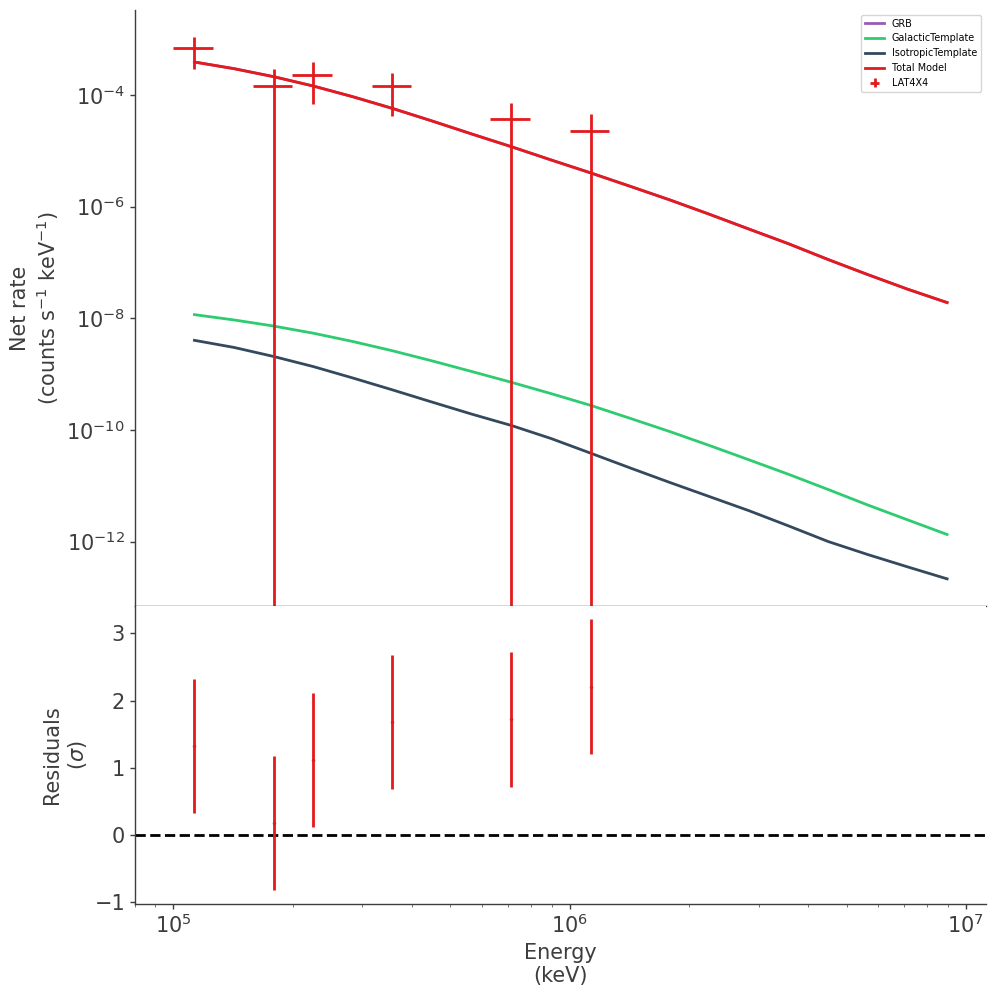

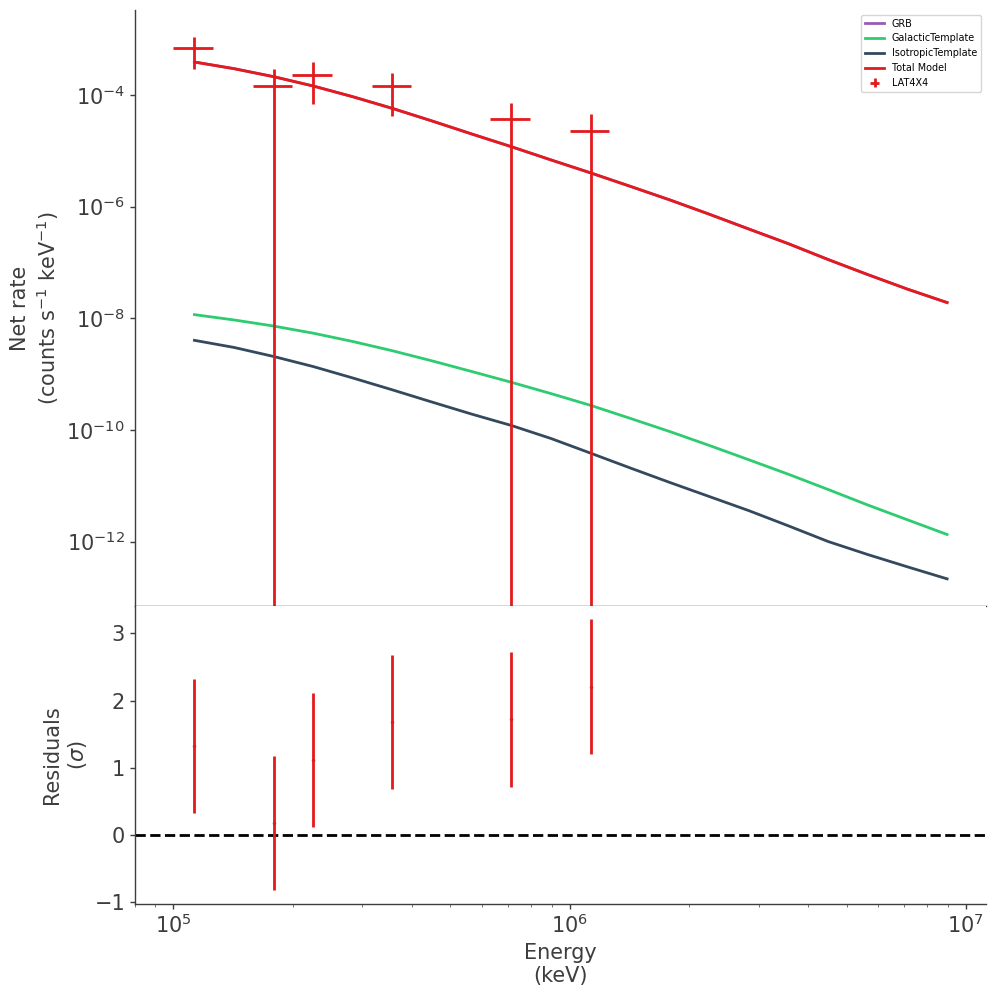

In [16]:
i = 3
T0, T1 = intervals[i], intervals[i + 1]
LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
jl = results[LAT_name]
jl.results.display()
display_spectrum_model_counts(jl, step=False, figsize=(10, 10))

We can see the evolution of the spectrum with time (not all the bins are diplayed):


processing MLE analyses:   0%|          | 0/13 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

22:28:49 DEBUG     converting MeV to MeV                                                          ]8;id=924739;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py\model_plot.py]8;;\:]8;id=674820;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py#890\890]8;;\

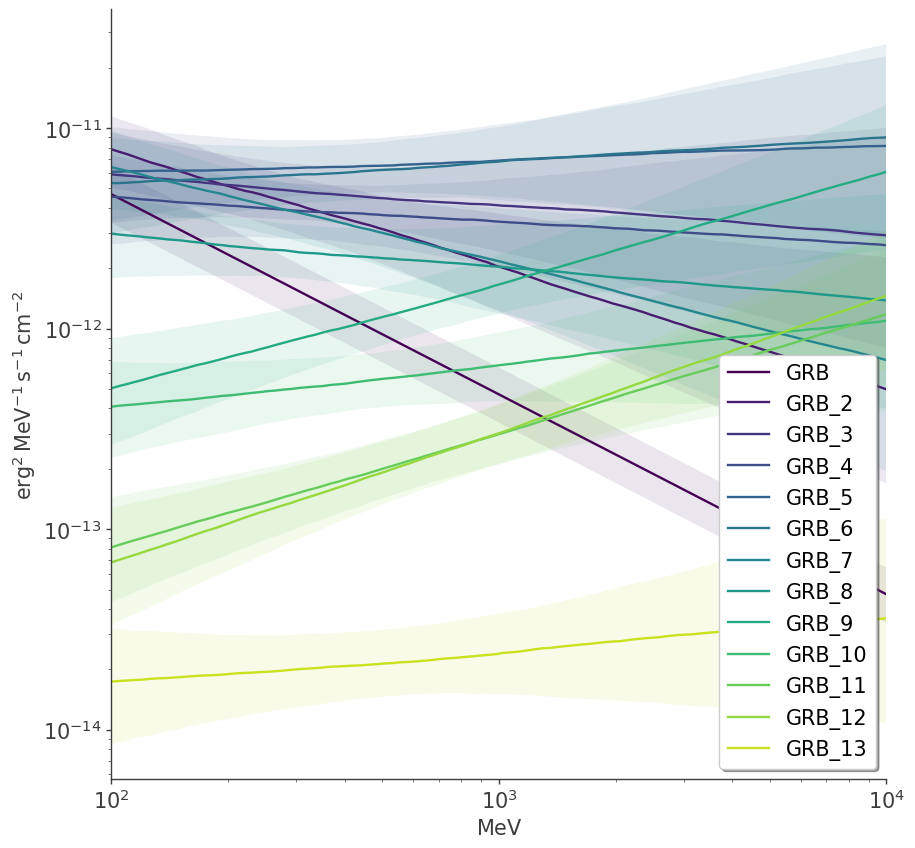

In [17]:
fig = plot_spectra(
    *[results[k].results for k in list(results.keys())[::2]],
    ene_min=100 * u.MeV,
    ene_max=10 * u.GeV,
    flux_unit="erg2/(cm2 s MeV)",
    energy_unit="MeV",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1)
)
fig.set_size_inches(10, 10)

Finally, we can display flux lightcurves and index evolution with time.


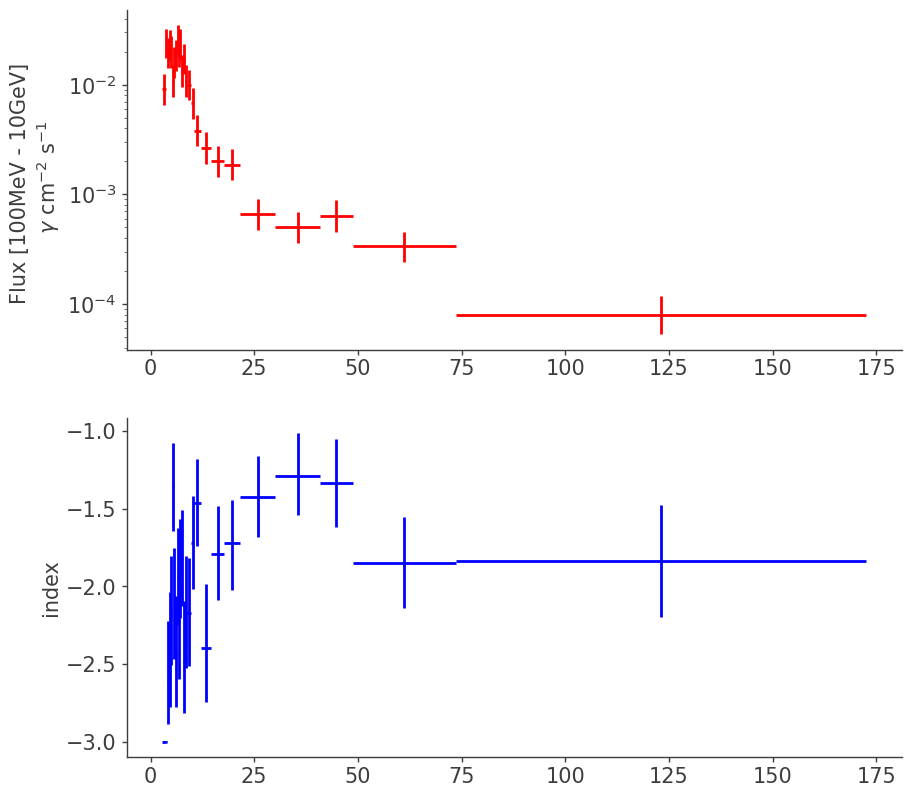

In [18]:
variates = ["F", "index"]
y = {}
for n in variates:
    y[n] = []
    y[n + "_p"] = []
    y[n + "_n"] = []
x = []
dx = []


for T0, T1 in zip(intervals[:-1], intervals[1:]):
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    x.append((T1 + T0) / 2)
    dx.append((T1 - T0) / 2)
    jl = results[LAT_name]
    res = jl.results
    mod = res.optimized_model
    ps = mod.point_sources

    for n in variates:
        my_variate = res.get_variates("GRB.spectrum.main.Powerlaw_flux.%s" % n)
        y[n].append(my_variate.median)
        y[n + "_p"].append(my_variate.equal_tail_interval()[1] - my_variate.median)
        y[n + "_n"].append(my_variate.median - my_variate.equal_tail_interval()[0])
        pass
    pass

fig = plt.figure(figsize=(10, 15))
colors = ["r", "b"]
ylabels = ["Flux [100MeV - 10GeV] \n $\gamma$ cm$^{-2}$ s$^{-1}$", "index"]
for i, n in enumerate(variates):
    plt.subplot(len(variates) + 1, 1, i + 1)
    plt.errorbar(x, y[n], xerr=dx, yerr=(y[n + "_n"], y[n + "_p"]), ls="", c=colors[i])
    if i == 0:
        plt.yscale("log")
    # plt.xscale('log')
    plt.ylabel(ylabels[i])
    pass